<a href="https://colab.research.google.com/github/sobhanshukueian/Unsupervised-Learning/blob/main/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %matplotlib inline
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import shutil
import cv2
import glob
import matplotlib
# matplotlib.use("TKAgg")
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 296

In [ ]:
root_path = "./data"
# Download Dataset
labeled = datasets.STL10(root=root_path, split='train', download=True)
unlabeled = datasets.STL10(root=root_path, split='unlabeled', download=True)
test = datasets.STL10(root=root_path, split="test", download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from PIL import ImageFilter
class GaussianBlur(object):
    def __init__(self, p=0.5, radius_min=0.1, radius_max=2.):
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        if torch.bernoulli(torch.tensor(self.prob)) == 0:
            return img

        radius = self.radius_min + torch.rand(1) * (self.radius_max - self.radius_min)
        return img.filter(ImageFilter.GaussianBlur(radius=radius))

# Resize the images and transform to tensors
def make_transforms(
    rand_size=96,
    focal_size=96,
    rand_crop_scale=(0.3, 1.0),
    color_jitter=1.0,
):
    def get_color_distortion(s=1.0):
        # s is the strength of color distortion.
        color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
        rnd_gray = transforms.RandomGrayscale(p=0.2)
        color_distort = transforms.Compose([
            rnd_color_jitter,
            rnd_gray])
        return color_distort

    rand_transform = transforms.Compose([
        transforms.RandomResizedCrop(rand_size, scale=rand_crop_scale),
        transforms.RandomHorizontalFlip(),
        # get_color_distortion(s=color_jitter),
        GaussianBlur(p=0.5),
        transforms.ToTensor(),
    ])
    return rand_transform

train_transformation = make_transforms()
val_transformation = transforms.Compose([transforms.Resize((96,96)), transforms.ToTensor()])

In [ ]:
class STL10Unlabeld(Dataset):
    def __init__(self, transform, dataset):
        self.transform = transform
        self.dataset=dataset

        self.classes=['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck','unlabelled']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label=self.dataset[index]


        # img0 = Image.open(img)
        # img1 = Image.open(img)


        # img0 = img0.convert("L")
        # img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img)
            img1 = self.transform(img)
        

        return img0, img1, label

In [ ]:
# Initialize the network
siamese_dataset = STL10Unlabeld(train_transformation, unlabeled)
siamese_testset = STL10Unlabeld(val_transformation, test)

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset, shuffle=False, num_workers=0, batch_size=BATCH_SIZE)

# Load the testing dataset
test_dataloader = DataLoader(siamese_testset, shuffle=False, num_workers=0, batch_size=BATCH_SIZE)

In [ ]:
train_features = next(iter(train_dataloader))
print(len(train_dataloader))
print("Train Images 1 Shape: {}\nTrain Images 2 Shape: {}\nTrain Data Labels Shape: {}".format(train_features[0].shape, train_features[1].shape, train_features[2].shape,))

test_features = next(iter(train_dataloader))
print(len(test_dataloader))
print("Test Images 1 Shape: {}\nTest Images 2 Shape: {}\nTest Data Labels Shape: {}".format(test_features[0].shape, test_features[1].shape, test_features[2].shape,))


338
Train Images 1 Shape: torch.Size([296, 3, 96, 96])
Train Images 2 Shape: torch.Size([296, 3, 96, 96])
Train Data Labels Shape: torch.Size([296])
28
Test Images 1 Shape: torch.Size([296, 3, 96, 96])
Test Images 2 Shape: torch.Size([296, 3, 96, 96])
Test Data Labels Shape: torch.Size([296])


In [ ]:
# Showing images
def show_batch(data, cols = BATCH_SIZE):
    fig, ax = plt.subplots(2, cols, figsize=(cols*20, 2*20))
    for index in range(cols):
        ax[0, index].imshow(data[0][index].view(3, 96, 96).permute(1 , 2 , 0), interpolation='nearest')
        ax[1, index].imshow(data[1][index].view(3, 96, 96).permute(1 , 2 , 0), interpolation='nearest')
    plt.show()
    print(data[2].numpy().reshape(-1))

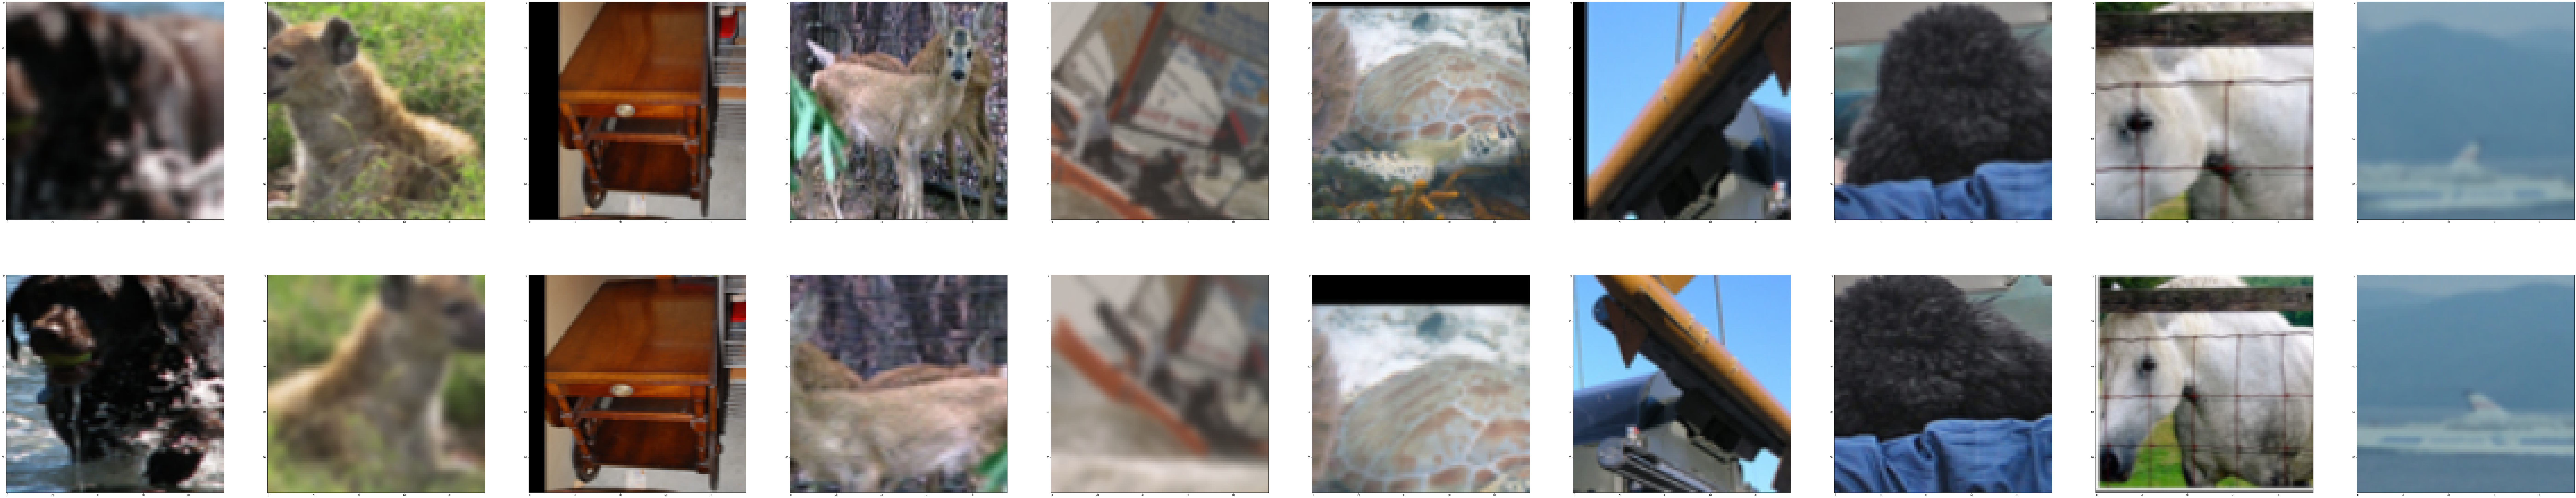

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=10)

# Extract one batch
example_batch = next(iter(vis_dataloader))
show_batch(example_batch, cols=10)

In [ ]:
OUTPUT_EMBEDDING_SIZE = 264

#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(5, 5, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(5),
            nn.Dropout(0.25),
            
            nn.Conv2d(5, 10, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(10, 10, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(10),
            nn.Dropout(0.25),

            nn.Conv2d(10, 15, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(15, 15, kernel_size=(4, 4)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(15, affine=False),
            nn.Dropout(0.25),

            nn.Conv2d(10, 15, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(15, affine=False),
            nn.Dropout(0.25),

            nn.Conv2d(15, 15, kernel_size=(3, 3)),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(15, OUTPUT_EMBEDDING_SIZE, kernel_size=(4, 16)),
            nn.BatchNorm2d(OUTPUT_EMBEDDING_SIZE)

        )
        # self.cnn2 = nn.Conv2d(15, OUTPUT_EMBEDDING_SIZE, kernel_size=(4, 16))
        self.f = nn.Flatten()
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = torch.mul(output, 1.4142135623730950488)
        # output = self.cnn2(output)
        output = self.f(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

    

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidean distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True).squeeze()
        # print(euclidean_distance)
        losses = (1-label) * torch.pow(euclidean_distance, 2) + (label) * 5 * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)    
        loss_contrastive = torch.mean(losses)
        # print(losses)
        return loss_contrastive, losses, euclidean_distance

In [ ]:
def get_color(idx):
    return list(matplotlib.colors.cnames.keys())[idx]
  
def get_colors(idxs):
    res = []
    for idx in idxs:
      res.append(get_color(idx))
    return res 

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'